In [1]:
%matplotlib inline

from scipy.special import erf, erfinv
from scipy.stats import norm

def _percentile_from_z_score(z_score):
    return 0.5*(1 + erf(z_score/np.sqrt(2)))

def _z_score_from_percentile(percentile):
    return np.sqrt(2)*erfinv(2*percentile-1)

In [2]:
from segregated_nfw_phase_space import SegregatedNFWPhaseSpace
seg_nfw = SegregatedNFWPhaseSpace()

from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
baseline_model = PrebuiltHodModelFactory('leauthaud11', redshift=0, threshold=9.5)

model = HodModelFactory(baseline_model_instance=baseline_model, 
                       satellites_profile=seg_nfw)

In [3]:
from halotools.sim_manager import CachedHaloCatalog, UserSuppliedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')

metadata = dict(Lbox=halocat.Lbox, 
               particle_mass=halocat.particle_mass, 
               redshift=halocat.redshift)

mask = halocat.halo_table['halo_mpeak'] > 10**11.25
halo_catalog_columns = {key: halocat.halo_table[key][mask] for key in halocat.halo_table.keys()}
halo_catalog_columns.update(metadata)
halocat = UserSuppliedHaloCatalog(**halo_catalog_columns)

In [4]:
from halotools.empirical_models import SubhaloPhaseSpace


host_haloprop_bins = np.logspace(10.6, 15.15, 10)
subhalo_phase_space = SubhaloPhaseSpace('satellites', host_haloprop_bins)

model = HodModelFactory(baseline_model_instance=baseline_model, 
                       satellites_profile=subhalo_phase_space)

model.populate_mock(halocat)

In [5]:
d = dict(halo_id=('halo_id', 'i8'), 
        halo_mpeak=('halo_mpeak', 'f8'))
subhalo_phase_space = SubhaloPhaseSpace('satellites', host_haloprop_bins,
                                        inherited_subhalo_props_dict=d)

from halotools.empirical_models import NFWPhaseSpace
unbiased_nfw = NFWPhaseSpace()


model_feature_calling_sequence = ['centrals_occupation', 'satellites_occupation', 
                                 'centrals_profile', 'satellites_profile', 'satellites_profile2']
model = HodModelFactory(baseline_model_instance=baseline_model, 
                       satellites_profile=subhalo_phase_space, 
                       satellites_profile2=unbiased_nfw, 
                       model_feature_calling_sequence=model_feature_calling_sequence)


In [6]:
model.populate_mock(halocat)

In [7]:
model.mock.populate()
gals = model.mock.galaxy_table
sats = gals[gals['gal_type'] == 'satellites']
cens = gals[gals['gal_type'] == 'centrals']

In [8]:
print(gals.keys())

['halo_upid', 'halo_mvir_host_halo_bin_number', 'halo_num_satellites', 'halo_hostid', 'halo_mpeak', 'conc_NFWmodel', 'halo_num_centrals', 'halo_y', 'halo_x', 'halo_id', 'halo_vx', 'halo_vy', 'halo_vz', '_subhalo_inheritance_id', 'halo_mvir_host_halo', 'halo_rvir', 'halo_z', 'halo_mvir', 'gal_type', 'vx', 'host_centric_distance', 'vy', 'y', 'x', 'vz', 'z', 'real_subhalo']


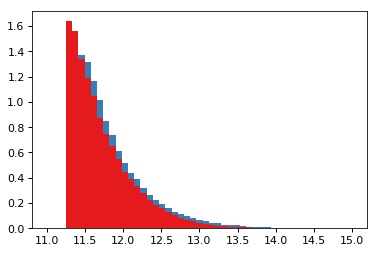

In [9]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(cens['halo_mpeak']), 
           bins=np.linspace(11, 15, 50), color=blue, normed=True)
__=ax.hist(np.log10(sats['halo_mpeak']), 
           bins=np.linspace(11, 15, 50), color=red, normed=True)


In [10]:
np.log10(gals['halo_mpeak'].min())

11.250175936209791

In [11]:
model.mean_log_halo_mass_centrals(log_stellar_mass=8.5)

10.873811020894768

In [12]:
mean_sm = model.mean_stellar_mass_centrals(prim_haloprop=sats['halo_mpeak'])

In [13]:
np.min(np.log10(mean_sm))

9.3612049288262398

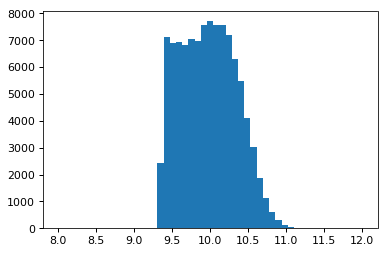

In [14]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(mean_sm), bins=np.linspace(8, 12, 50))

In [15]:
zmax = (model.threshold - np.min(np.log10(mean_sm)))/0.2
u = np.random.uniform(_percentile_from_z_score(zmax), 1, int(1e4))

r = norm.isf(1 - u)

r.min(), r.mean(), r.max()

(0.69405096019197177, 1.2892031674239017, 4.5828661239615087)

In [16]:
model.param_dict

{'alphasat': 1.0,
 'bcut': 1.47,
 'betacut': -0.13,
 'betasat': 0.859,
 'bsat': 10.62,
 u'scatter_model_param1': 0.2,
 u'smhm_beta_0': 0.43,
 u'smhm_beta_a': 0.18,
 u'smhm_delta_0': 0.56,
 u'smhm_delta_a': 0.18,
 u'smhm_gamma_0': 1.54,
 u'smhm_gamma_a': 2.52,
 u'smhm_m0_0': 10.72,
 u'smhm_m0_a': 0.59,
 u'smhm_m1_0': 12.35,
 u'smhm_m1_a': 0.3}

In [17]:
mean_logsm = np.log10(model.mean_stellar_mass_centrals(prim_haloprop=gals['halo_mpeak']))

In [18]:
dlogsm = (mean_logsm - model.threshold)
dlogsm_zscore = dlogsm/model.param_dict[u'scatter_model_param1']

dlogsm_zscore.min(), dlogsm_zscore.mean(), dlogsm_zscore.max()

(-0.6939753558688011, 2.6815703750086963, 9.007924106733034)

In [19]:
dlogsm_percentile = _percentile_from_z_score(dlogsm_zscore)

dlogsm_percentile.min(), dlogsm_percentile.mean(), dlogsm_percentile.max()

(0.24384883200203866, 0.90320117983260007, 1.0)

In [20]:
u = 1 - np.random.uniform(0, dlogsm_percentile)
logsm = norm.isf(1 - u, loc=mean_logsm, 
              scale=model.param_dict[u'scatter_model_param1'])

In [21]:
from csmf_from_hod import kernel

model_logsm = kernel(model)

In [22]:
logsm.min(), logsm.mean(), logsm.max()

(9.5000004661855755, 10.069309140567475, 11.711389719417474)

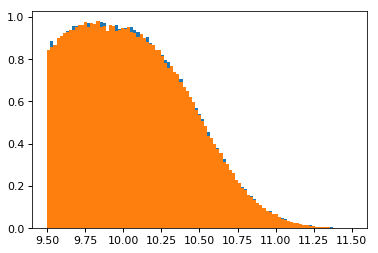

In [23]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(logsm, bins=np.linspace(9.5, 11.5, 100), normed=True)
__=ax.hist(model_logsm, bins=np.linspace(9.5, 11.5, 100), normed=True)

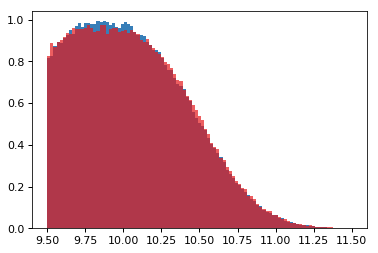

In [24]:
from halotools.empirical_models import Behroozi10SmHm
behroozi = Behroozi10SmHm()

bsm = behroozi.mc_stellar_mass(prim_haloprop=halocat.halo_table['halo_mpeak'], redshift=0)
beh_mask = bsm > 10**9.5
beh_mpeak = halocat.halo_table['halo_mpeak'][beh_mask]
beh_sm = bsm[beh_mask]

fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(beh_sm), bins=np.linspace(9.5, 11.5, 100), normed=True, color=blue)
__=ax.hist(logsm, bins=np.linspace(9.5, 11.5, 100), normed=True, color=red, alpha=0.7)

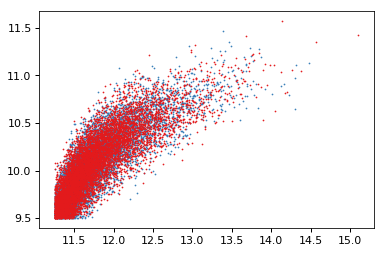

In [25]:
fig, ax = plt.subplots(1, 1)

x = np.log10(beh_mpeak)
y = np.log10(beh_sm)
len(beh_sm), len(beh_mask)
__=ax.scatter(x[::50], y[::50], s=0.5, color=blue)

x2 = np.log10(gals['halo_mpeak'])
y2 = logsm
__=ax.scatter(x2[::50], y2[::50], s=0.5, color=red)
